# Домашнее задание №8. Синтез изображений.

In [62]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [63]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Задание
Реализовать синтезирование лиц из LFW с помощью DCGAN.

Библиотеки: [Python, Tensorflow].



## План решения
[0. Загрузка и просмотр данных](#section_0)

[1. Подготовка пайплайна данных](#section_1)

[2. Построение модели DCGAN](#section_2)

[3. Тестирование сверточного генератора](#section_3)
    
[4. Интерполяция в латентном пространстве](#section_4)

### 0. Загрузка и просмотр данных <a id='section_0'></a>

In [64]:
#загрузка датасета
train_ds, ds_info = tfds.load('lfw', #название датасета
                              as_supervised=True, #получаем кортеж(features, label)
                              with_info=True,  #метаданные
                              split='train') #какой раздел считываем

In [65]:
#признаки датасета
ds_info.features

FeaturesDict({
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
    'label': Text(shape=(), dtype=tf.string),
})

In [66]:
#Количество экземпляров в датасете
len(train_ds)

13233

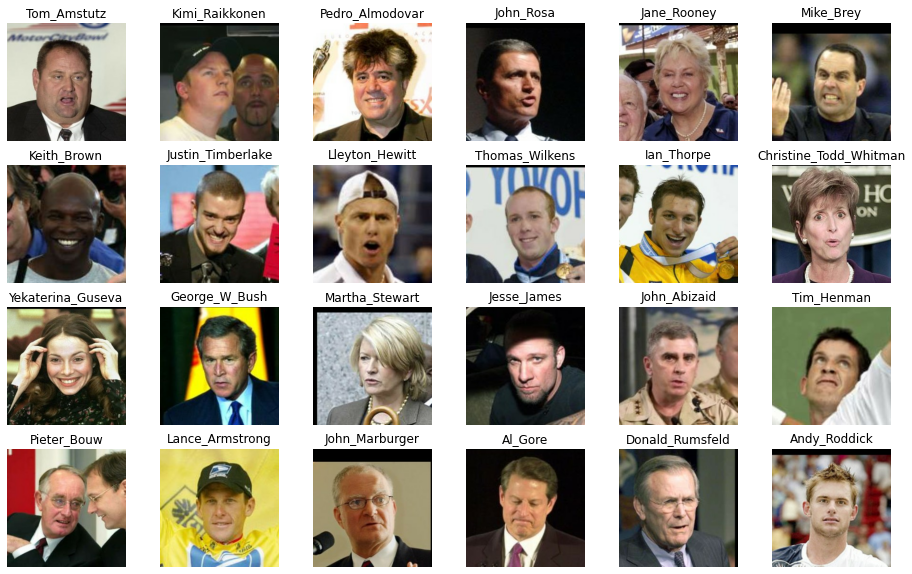

In [67]:
#визуализация датасета
plt.figure(figsize=(16, 10))
for j, (label, image) in enumerate(train_ds.take(24)):
    plt.subplot(4, 6, j+1)
    plt.title(label.numpy().decode('utf-8')) 
    plt.imshow(image)
    plt.axis('off')

### 1. Подготовка пайплайна данных <a id='section_1'></a>

In [68]:
#создание датасета
INPUT_DIM = 100
INP_SIZE = 64
NUM_EPOCHS = 50
HALF_BATCH_SIZE = 16  # размер батча генерируемых картинок
BATCH_SIZE = HALF_BATCH_SIZE * 2  # вторая половина батча - реальные картинки
LEARNING_RATE = 0.0002

def preprocessing(img):
  img = (tf.cast(img, tf.float32) - 127.5) / 127.5  #преобразование к значениям [-1;1]
  return tf.image.resize(img, (INP_SIZE, INP_SIZE))

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(lambda label, img: (preprocessing(img), label))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [69]:
#размеры картинок и лейблов в датасете
for image, label in train_ds:
  print(image.shape)
  print(label.shape)
  break

(16, 64, 64, 3)
(16,)


### 2. Построение модели Deep Convolutional GAN (DCGAN) <a id='section_2'></a>

In [70]:
#генератор
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*16*16, activation='relu'),
    tf.keras.layers.Reshape((16, 16, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

#пример работы генератора
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
syntetic_images.shape

(16, 64, 64, 3)

In [71]:
#дискриминатор
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

#пример работы дискриминатора
decision = discriminator(syntetic_images)
print(decision)

tf.Tensor(
[[ 1.3054211e-03]
 [-2.3568908e-04]
 [ 3.1990486e-03]
 [ 3.6536106e-03]
 [ 2.8244455e-03]
 [ 1.5717715e-03]
 [-1.4529796e-04]
 [ 6.9916795e-04]
 [ 1.2469084e-03]
 [ 1.4405649e-03]
 [-2.6544638e-04]
 [ 2.8416775e-03]
 [ 4.1943043e-05]
 [ 1.2004591e-03]
 [ 1.5099370e-03]
 [ 2.6616524e-04]], shape=(16, 1), dtype=float32)


In [72]:
#компиляция модели
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [73]:
#функция визуализации предсказаний модели
def plot_results(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.6695; G Loss: 0.6328


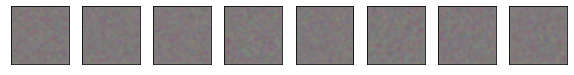

[Step 500] D Loss: 0.0074; G Loss: 5.7406


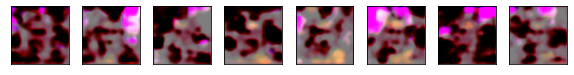

[Step 1000] D Loss: 0.3865; G Loss: 1.6120


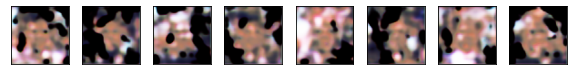

[Step 1500] D Loss: 0.1503; G Loss: 1.4611


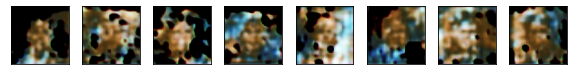

[Step 2000] D Loss: 0.1637; G Loss: 2.9661


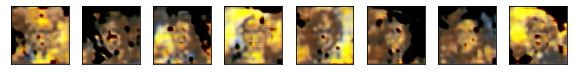

[Step 2500] D Loss: 0.9994; G Loss: 2.2904


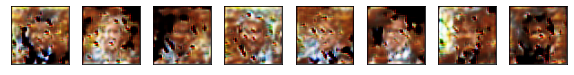

[Step 3000] D Loss: 0.3901; G Loss: 1.6053


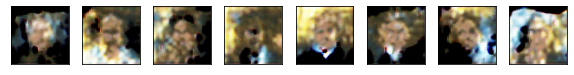

[Step 3500] D Loss: 1.0528; G Loss: 0.6242


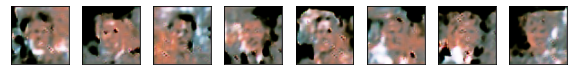

[Step 4000] D Loss: 1.0960; G Loss: 1.0451


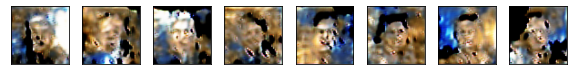

[Step 4500] D Loss: 0.5857; G Loss: 1.1364


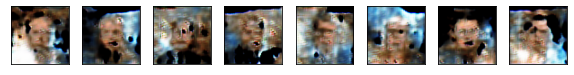

[Step 5000] D Loss: 0.8360; G Loss: 0.6374


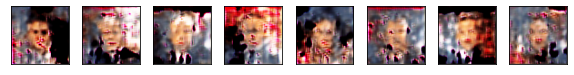

[Step 5500] D Loss: 0.8986; G Loss: 0.5447


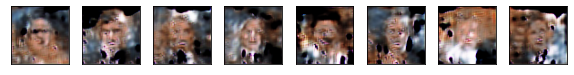

[Step 6000] D Loss: 0.3648; G Loss: 1.8582


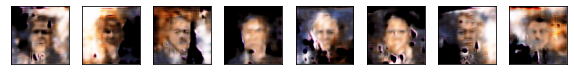

[Step 6500] D Loss: 0.0150; G Loss: 4.2975


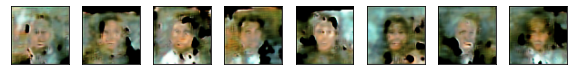

[Step 7000] D Loss: 0.2372; G Loss: 2.9429


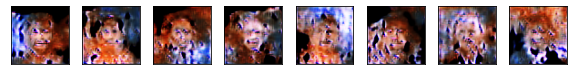

[Step 7500] D Loss: 0.0064; G Loss: 5.7188


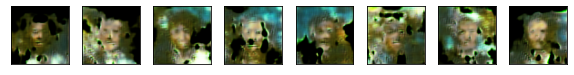

[Step 8000] D Loss: 0.2449; G Loss: 1.6218


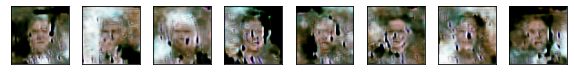

[Step 8500] D Loss: 0.1922; G Loss: 3.3197


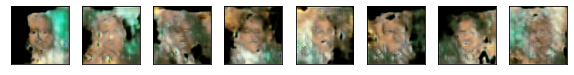

[Step 9000] D Loss: 0.4186; G Loss: 3.5716


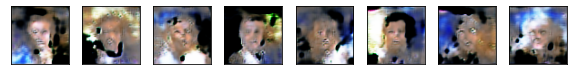

[Step 9500] D Loss: 0.2678; G Loss: 3.2786


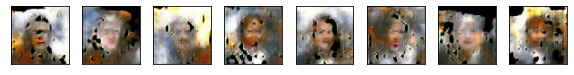

[Step 10000] D Loss: 0.1750; G Loss: 1.5100


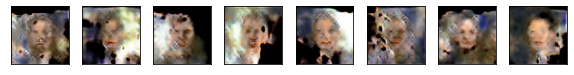

[Step 10500] D Loss: 0.2050; G Loss: 5.9170


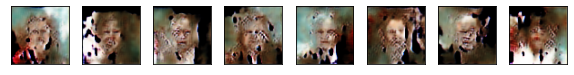

[Step 11000] D Loss: 0.5374; G Loss: 4.7677


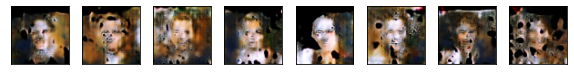

[Step 11500] D Loss: 0.4510; G Loss: 4.8110


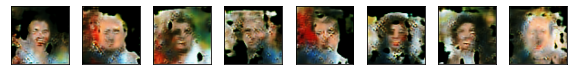

[Step 12000] D Loss: 0.4108; G Loss: 3.1999


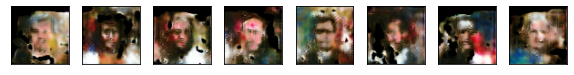

[Step 12500] D Loss: 0.2552; G Loss: 2.6672


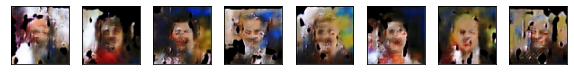

[Step 13000] D Loss: 0.2300; G Loss: 2.8428


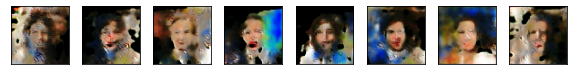

[Step 13500] D Loss: 0.3002; G Loss: 3.1867


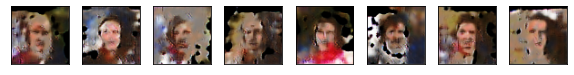

[Step 14000] D Loss: 0.3402; G Loss: 2.2353


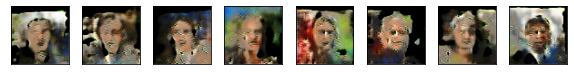

[Step 14500] D Loss: 0.2452; G Loss: 3.4082


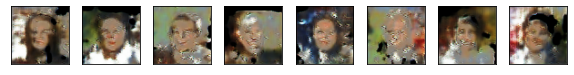

[Step 15000] D Loss: 0.4774; G Loss: 3.3699


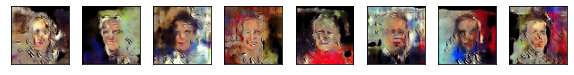

[Step 15500] D Loss: 0.3947; G Loss: 4.4354


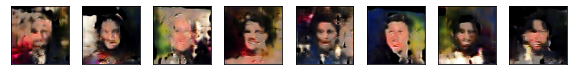

[Step 16000] D Loss: 0.4639; G Loss: 2.7900


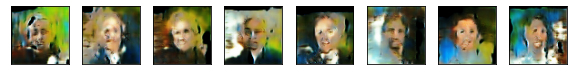

[Step 16500] D Loss: 0.4060; G Loss: 2.8952


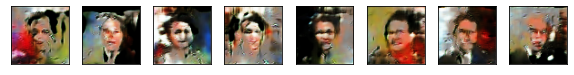

[Step 17000] D Loss: 0.3745; G Loss: 2.7945


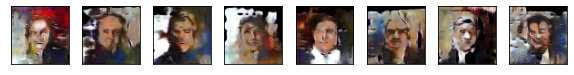

[Step 17500] D Loss: 0.5657; G Loss: 1.3290


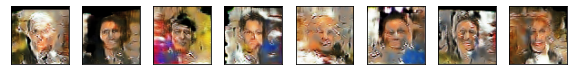

[Step 18000] D Loss: 0.4940; G Loss: 2.8826


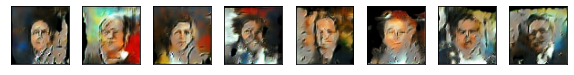

[Step 18500] D Loss: 0.2968; G Loss: 1.7014


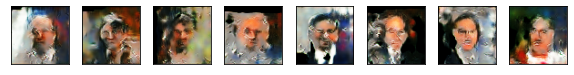

[Step 19000] D Loss: 0.6810; G Loss: 1.5693


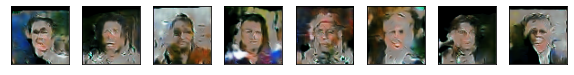

[Step 19500] D Loss: 0.1564; G Loss: 3.3860


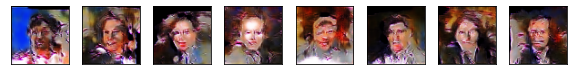

[Step 20000] D Loss: 0.2370; G Loss: 1.9921


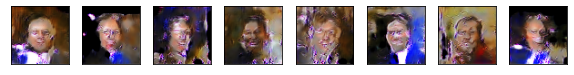

[Step 20500] D Loss: 0.7197; G Loss: 1.1763


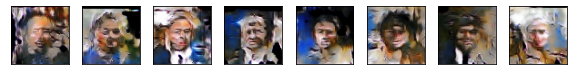

[Step 21000] D Loss: 0.5592; G Loss: 2.4512


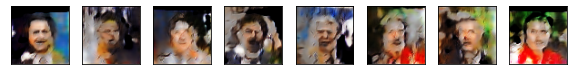

[Step 21500] D Loss: 0.5250; G Loss: 2.4785


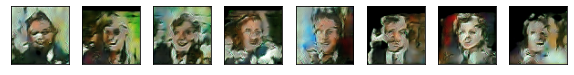

[Step 22000] D Loss: 0.2787; G Loss: 2.5803


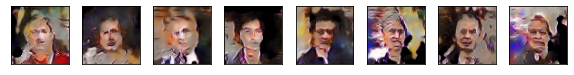

[Step 22500] D Loss: 0.5692; G Loss: 2.7747


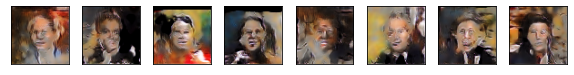

[Step 23000] D Loss: 0.3935; G Loss: 2.5660


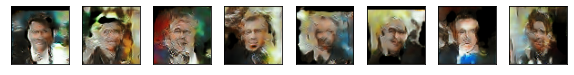

[Step 23500] D Loss: 0.6967; G Loss: 1.0872


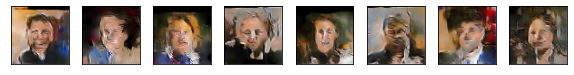

[Step 24000] D Loss: 0.3115; G Loss: 3.0052


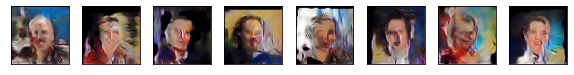

[Step 24500] D Loss: 0.7706; G Loss: 1.6911


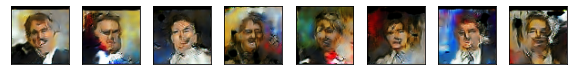

[Step 25000] D Loss: 0.4741; G Loss: 1.1459


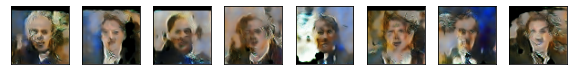

[Step 25500] D Loss: 0.3110; G Loss: 1.7635


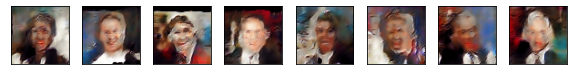

[Step 26000] D Loss: 0.4001; G Loss: 2.7271


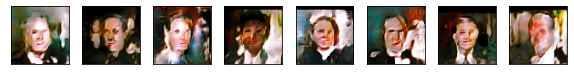

[Step 26500] D Loss: 0.7189; G Loss: 1.6182


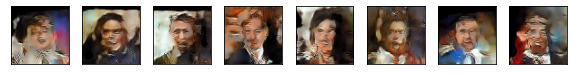

[Step 27000] D Loss: 0.6454; G Loss: 0.8696


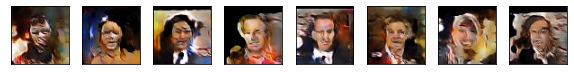

[Step 27500] D Loss: 0.4109; G Loss: 1.2016


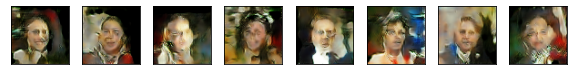

[Step 28000] D Loss: 0.6242; G Loss: 1.3291


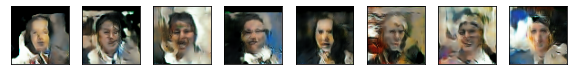

[Step 28500] D Loss: 0.2850; G Loss: 2.4313


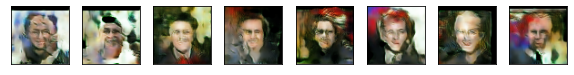

[Step 29000] D Loss: 0.6892; G Loss: 0.8375


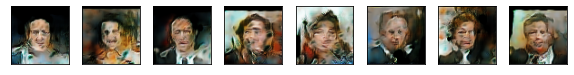

[Step 29500] D Loss: 0.3366; G Loss: 1.3193


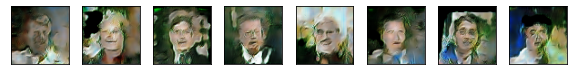

[Step 30000] D Loss: 0.4458; G Loss: 1.5418


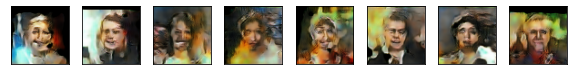

[Step 30500] D Loss: 0.7100; G Loss: 1.3226


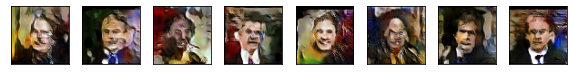

[Step 31000] D Loss: 0.6094; G Loss: 1.0360


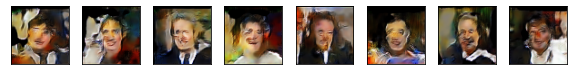

[Step 31500] D Loss: 0.5273; G Loss: 1.0034


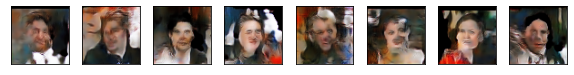

[Step 32000] D Loss: 0.5508; G Loss: 0.6261


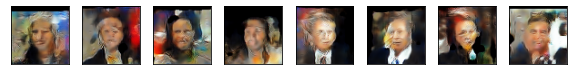

[Step 32500] D Loss: 0.7165; G Loss: 1.3459


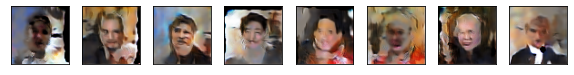

[Step 33000] D Loss: 0.4666; G Loss: 1.6931


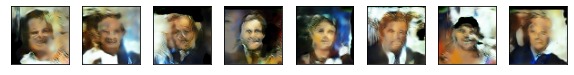

[Step 33500] D Loss: 0.3473; G Loss: 1.6009


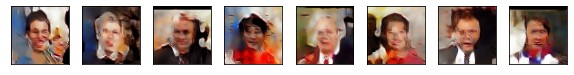

[Step 34000] D Loss: 0.6058; G Loss: 1.0062


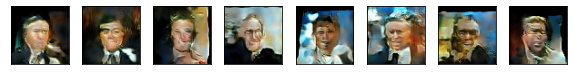

[Step 34500] D Loss: 0.4185; G Loss: 1.3648


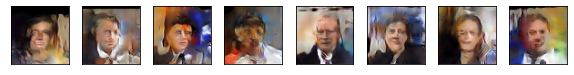

[Step 35000] D Loss: 0.4280; G Loss: 1.4796


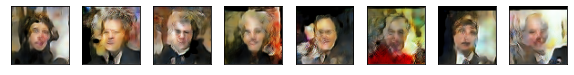

[Step 35500] D Loss: 0.5214; G Loss: 1.4523


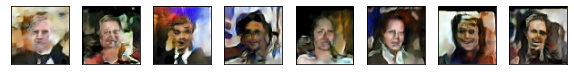

[Step 36000] D Loss: 0.5493; G Loss: 1.0954


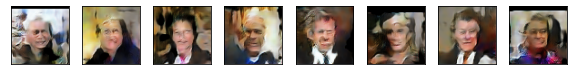

[Step 36500] D Loss: 0.7192; G Loss: 1.8603


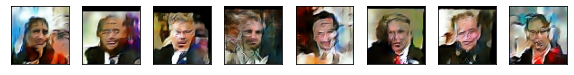

[Step 37000] D Loss: 0.2839; G Loss: 0.7832


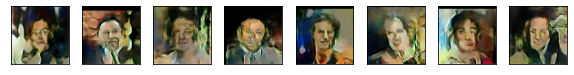

[Step 37500] D Loss: 0.6331; G Loss: 0.6845


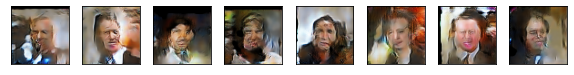

[Step 38000] D Loss: 0.3658; G Loss: 1.7019


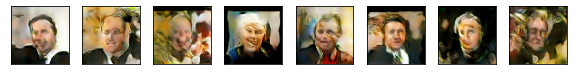

[Step 38500] D Loss: 0.4664; G Loss: 1.0045


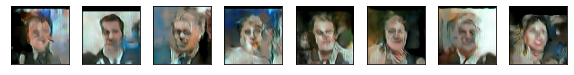

[Step 39000] D Loss: 0.6185; G Loss: 1.6316


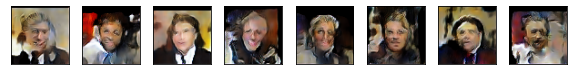

[Step 39500] D Loss: 0.5456; G Loss: 1.5198


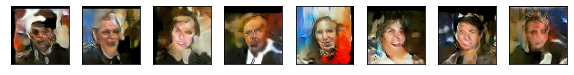

[Step 40000] D Loss: 0.4572; G Loss: 1.6963


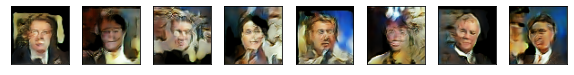

[Step 40500] D Loss: 0.5600; G Loss: 0.8677


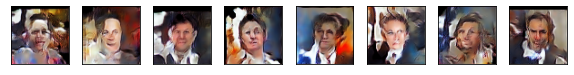

[Step 41000] D Loss: 0.4875; G Loss: 1.1340


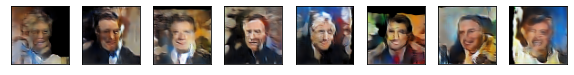

In [74]:
#обучение модели
for step, (true_images, labels) in enumerate(train_ds):
     
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_results(syntetic_images)

### 3. Тестирование свeрточного генератора <a id='section_3'></a>

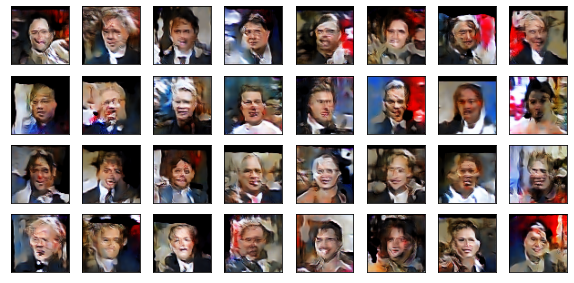

In [75]:
#пример работы обученного генератора
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)

### 4. Интерполяция в латентном пространстве <a id='section_4'></a>

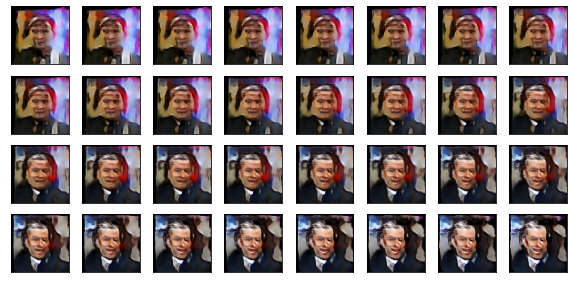

In [76]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)